# The Context Manager aka the Measurement Object

This notebook shows some ways of performing different measurements using 
QCoDeS parameters and the new DataSet accessed via a context manager.


In [ ]:
%matplotlib notebook
from collections import OrderedDict
from typing import Dict, Callable
from inspect import signature
import numpy.random as rd
import matplotlib.pyplot as plt
import json
from functools import partial
import numpy as np

from time import sleep

import qcodes as qc
from qcodes import Station
from qcodes.dataset.experiment_container import Experiment
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.param_spec import ParamSpec
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id


In [2]:
# a generator to simulate a physical signal, in this case an exponentially
# decaying signal

def exponential_decay(a: float, b: float):
    """
    Yields a*exp(-b*x) where x is put in 
    """
    x = 0
    while True:
        x = yield
        yield a*np.exp(-b*x) + 0.02*a*np.random.randn()

In [3]:
# preparatory mocking of physical setup

dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])

station = qc.Station(dmm, dac)

DEBUG:root:Error getting or interpreting *IDN?: ''
DEBUG:root:Error getting or interpreting *IDN?: ''


In [4]:
# and then a bit of "wiring" to make the dmm "measure"
# the exponential decay

ed = exponential_decay(5, 0.2)
next(ed)

def customgetter(dac):
    val = ed.send(dac.ch1())
    next(ed)
    return val
    
dmm.v1.get = partial(customgetter, dac)

In [5]:
# now make some silly set-up and tear-down actions

def veryfirst():
    print('Starting the measurement')

def numbertwo(inst1, inst2):
    print('Doing stuff with the following two instruments: {}, {}'.format(inst1, inst2))
    
def thelast():
    print('End of experiment')

In [6]:
# And then run an experiment

meas = Measurement()
meas.registerParameter(dac.ch1)  # register the first independent parameter
meas.registerParameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone
meas.addBeforeRun(veryfirst, ())  # add a set-up action
meas.addBeforeRun(numbertwo, (dmm, dac))  # add another set-up action
meas.addAfterRun(thelast, ())  # add a tear-down action

with meas.run() as datasaver:
        
    for set_v in np.linspace(0, 25, 100):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.addResult((dac.ch1, set_v),
                            (dmm.v1, get_v))
        
    
    dataid = datasaver.id  # convenient to have for plotting

DEBUG:qcodes.dataset.measurements:Flushing to database
DEBUG:qcodes.dataset.measurements:Succesfully wrote from index 0


Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 84
End of experiment


<IPython.core.display.Javascript object>


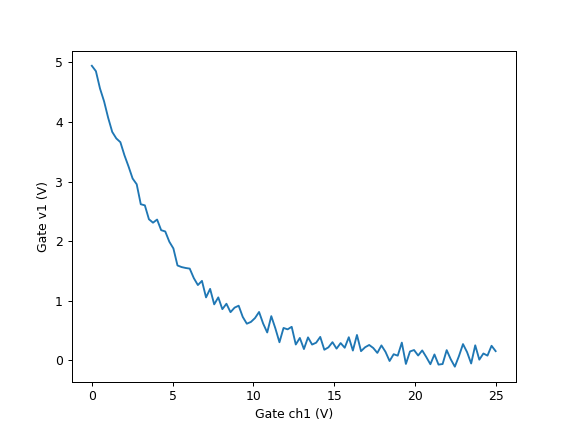

In [7]:
plot_by_id(dataid)

## The power of the new construct

This new form is so free that we may easily do thing impossible with the old Loop construct

In [8]:
# from the above plot, we decide that a voltage below 
# 1 V is uninteresting, so we stop the sweep at that point
# thus, we do not know in advance how many points we'll measure

with meas.run() as datasaver:
        
    for set_v in np.linspace(0, 25, 100):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()        
        datasaver.addResult((dac.ch1, set_v),
                            (dmm.v1, get_v))

        if get_v < 1:
            break
        
    
    dataid = datasaver.id  # convenient to have for plotting

DEBUG:qcodes.dataset.measurements:Flushing to database
DEBUG:qcodes.dataset.measurements:Succesfully wrote from index 0


Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 85
End of experiment


<IPython.core.display.Javascript object>


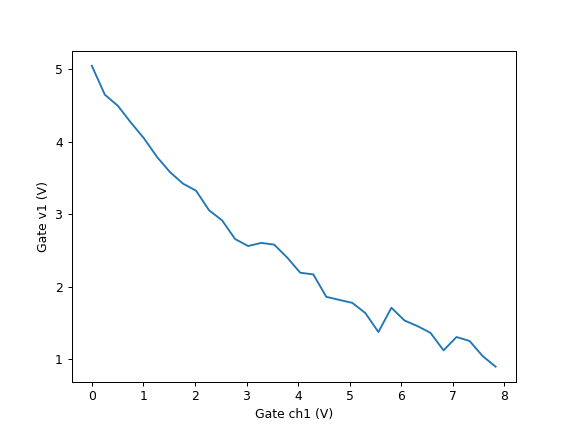

In [9]:
plot_by_id(dataid)

In [11]:
# Or we might want to simply get as many points as possible in 10 s
# randomly sampling the region between 0 V and 5 V (for the setpoint axis)

from time import monotonic, sleep

with meas.run() as datasaver:
    
    t_start = monotonic()
    
    while monotonic() - t_start < 10:
        set_v = 5/2*(np.random.rand() + 1)
        dac.ch1.set(set_v)
        
        # some sleep to not get too many points (or to let the system settle)
        sleep(0.1)
        
        get_v = dmm.v1.get()        
        datasaver.addResult((dac.ch1, set_v),
                            (dmm.v1, get_v))
    
    dataid = datasaver.id  # convenient to have for plotting

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 87


DEBUG:qcodes.dataset.measurements:Flushing to database
DEBUG:qcodes.dataset.measurements:Succesfully wrote from index 0
DEBUG:qcodes.dataset.measurements:Flushing to database
DEBUG:qcodes.dataset.measurements:Succesfully wrote from index 49


End of experiment


<IPython.core.display.Javascript object>


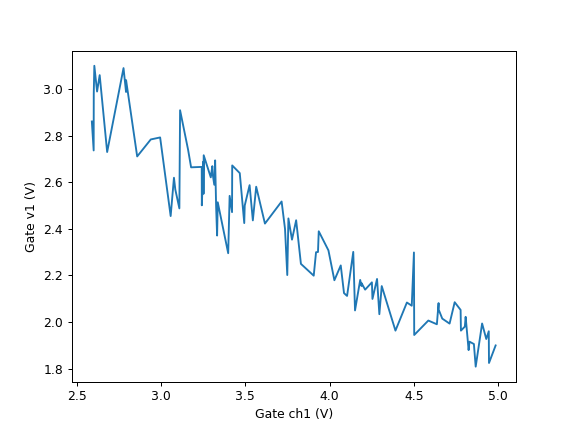

In [15]:
fig = plot_by_id(dataid)

In [16]:
ax = fig.axes[0]

AttributeError: 'NoneType' object has no attribute 'axes'